In [1]:
import tushare as ts
token = '6feca07b866ea55bd6024aa5a8891d7bc11afd829d1386c8a2fc8d89'
pro = ts.pro_api(token)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import pandas as pd
import numpy as np
import time
import requests
from IPython.core.display import HTML

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# choose fund
start_date_str = '20160101'
end_date_str = '20171231'

In [4]:
def get_price(code_name, code, start_date_str, end_date_str):
    p_t = ['trade_date', 'close'] #['trade_date', 'open', 'high', 'low', 'close', 'vol', 'pct_chg']
    
    #get data
    price = pro.fund_daily(ts_code=code, start_date=start_date_str, end_date=end_date_str)

    # set date index and resort data
    p = price[p_t].sort_values(by='trade_date')
    p['trade_date'] = pd.to_datetime(p['trade_date'])
    p.set_index("trade_date", inplace=True)
    
    p = p.rename({'close':code_name}, axis=1)
    
    return p

In [5]:
# get data
ticks = {
    'ETF300':'510310.SH'
}
c = 'ETF300'
p = get_price(c,ticks[c],start_date_str, end_date_str)

In [6]:
# calc ma
mp = 30
p['ma'] = p[c].rolling(mp,center=False,min_periods=1).mean()
# calc diff
p['diff'] = p[c]/p['ma']-1

# return
p['r']=p[c].pct_change()

# slope
p['d']=p['diff'].pct_change()

p = p.drop(p.index[[0]])

 Four scenarios: 

1) low R-square and low p-value (p-value <= 0.05)

2) low R-square and high p-value (p-value > 0.05)

3) high R-square and low p-value

4) high R-square and high p-value

Interpretation:

1) means that your model doesn't explain much of variation of the data but it is significant (better than not having a model)

2) means that your model doesn't explain much of variation of the data and it is not significant (worst scenario)

3) means your model explains a lot of variation within the data and is significant (best scenario)

4) means that your model explains a lot of variation within the data but is not significant (model is worthless)

### 以价格与均线的距离为x，与回报r做线性回归

In [16]:
x = p['diff'].values
y = p['r'].values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     369.3
Date:                Sun, 10 Mar 2019   Prob (F-statistic):           7.28e-43
Time:                        04:53:22   Log-Likelihood:                -3696.1
No. Observations:                 156   AIC:                             7394.
Df Residuals:                     155   BIC:                             7397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2715      0.014     19.218      0.000       0.244       0.299
==============================================================================
Omnibus:                       18.545   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.541
Skew:                           0.807   Prob(JB):                     2.10e-05
Kurtosis:                       3.842   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

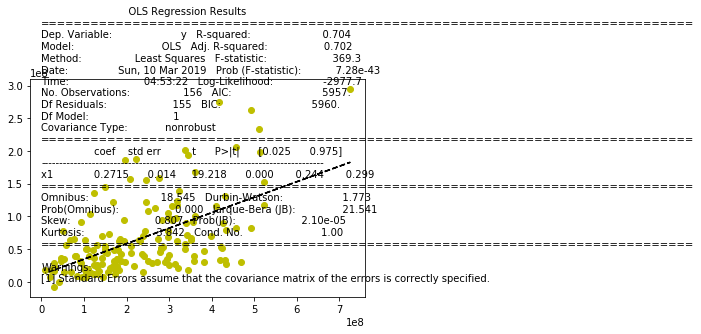

In [36]:
x=x
y=y
plt.text(.5, .8,results.summary())
m,b = np.polyfit(x, y, 1) 
plt.plot(x, y, 'yo', x, m*x+b, '--k') 
#x = sm.add_constant((x*100), prepend=True)
x=x*100
y=y*100
results = smf.OLS(y,x).fit()
display(results.summary())

y=0.1219*x

x 是 价格与均线的距离，价格越小于均线，价格越可能下跌，同样，价格越高于均线，价格越可能上涨。

R2只有10.4%，说明距离对价格的线性关系并不强。

另外，这个模型没有考虑距离的斜率。当距离为负值时，斜率越大下跌可能性越大，斜率变小下跌可能性减小；当距离为正值时，斜率越大上涨可能性越大，斜率变小上涨可能性减小。

### 考虑距离的斜率，按斜率分类，再对回报r及距离做线性回归

距离变化为负值分为一类，变化为正值分为一类

In [20]:
p1=p[p['d']<0]
p2=p[p['d']>=0]

In [21]:
x1 = p1['diff'].values
y1 = p1['r'].values
x2 = p2['diff'].values
y2 = p2['r'].values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     26.51
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           5.13e-07
Time:                        15:23:39   Log-Likelihood:                -342.01
No. Observations:                 266   AIC:                             686.0
Df Residuals:                     265   BIC:                             689.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1213      0.024     -5.148      0.000      -0.168      -0.075
==============================================================================
Omnibus:                       85.462   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1061.326
Skew:                          -0.883   Prob(JB):                    3.44e-231
Kurtosis:                      12.625   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

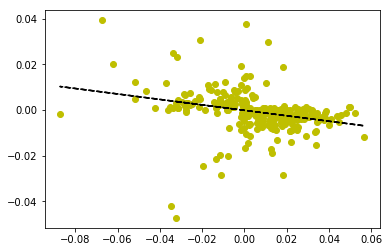

In [22]:
x=x1
y=y1
m,b = np.polyfit(x, y, 1) 
plt.plot(x, y, 'yo', x, m*x+b, '--k') 
#x = sm.add_constant((x1*100), prepend=True)
x=x1*100
y=y1*100
results = smf.OLS(y,x).fit()
display(results.summary())

y = -0.1213*x

这个模型考虑了斜率，价格距离均线的斜率为负值（由+转-，及继续为-），即”从最正距离转为最负距离“，做了r与距离的线性回归。

R2只有9.1%，说明”从最正距离转为最负距离“这段区间，距离对价格的线性关系并不强。

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     479.8
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           4.32e-57
Time:                        15:26:42   Log-Likelihood:                -197.39
No. Observations:                 220   AIC:                             396.8
Df Residuals:                     219   BIC:                             400.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2975      0.014     21.904      0.000       0.271       0.324
==============================================================================
Omnibus:                       95.902   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              855.462
Skew:                          -1.430   Prob(JB):                    1.73e-186
Kurtosis:                      12.227   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

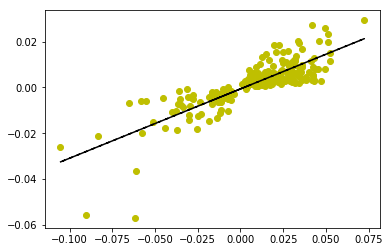

In [23]:
x=x2
y=y2
m,b = np.polyfit(x, y, 1) 
plt.plot(x, y, 'yo', x, m*x+b, '--k') 
#x = sm.add_constant((x2*100), prepend=True)
x=x2*100
y=y2*100
results = smf.OLS(y,x).fit()
display(results.summary())

y = 0.2975*x

这个模型考虑了斜率，价格距离均线的斜率为正（由-转+，及继续为+），即“从最负距离转为最正距离”，做了r与距离的线性回归。

R2只有68.7%，说明在“从最负距离转为最正距离”这段区间，距离对价格的线性关系并比较显著。

### 进一步细分

正距离按正负斜率分、负距离按正负斜率分，共分为四组

In [24]:
p1=p[p['diff']<0]
p2=p[p['diff']>=0]

In [25]:
p11=p1[p1['d']<0]
p12=p1[p1['d']>=0]
p21=p2[p2['d']<0]
p22=p2[p2['d']>=0]

距离负、斜率负：从相交点向下，线性回归不显著

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     5.579
Date:                Sat, 09 Mar 2019   Prob (F-statistic):             0.0203
Time:                        15:30:19   Log-Likelihood:                -144.57
No. Observations:                  91   AIC:                             291.1
Df Residuals:                      90   BIC:                             293.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1206      0.051     -2.362      0.020      -0.222      -0.019
==============================================================================
Omnibus:                       43.209   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.942
Skew:                          -1.502   Prob(JB):                     3.06e-35
Kurtosis:                       8.736   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

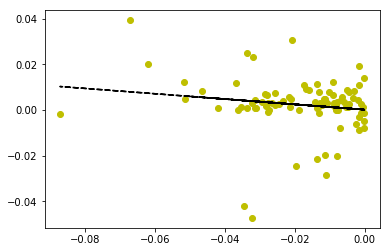

In [28]:
x = p11['diff'].values
y = p11['r'].values
m,b = np.polyfit(x, y, 1) 
plt.plot(x, y, 'yo', x, m*x+b, '--k') 
#x = sm.add_constant((x*100), prepend=True)
x=x*100
y=y*100
results = smf.OLS(y,x).fit()
display(results.summary())

距离负、斜率正：从低点向上，线性回归比较显著，R2为68.5%

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     136.8
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           1.96e-17
Time:                        15:30:35   Log-Likelihood:                -76.565
No. Observations:                  64   AIC:                             155.1
Df Residuals:                      63   BIC:                             157.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3342      0.029     11.695      0.000       0.277       0.391
==============================================================================
Omnibus:                       39.428   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.380
Skew:                          -1.764   Prob(JB):                     2.43e-30
Kurtosis:                       9.221   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

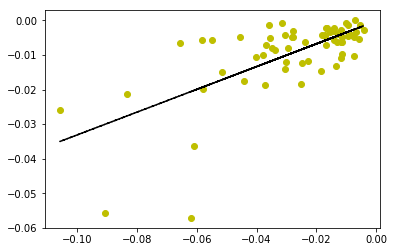

In [29]:
x = p12['diff'].values
y = p12['r'].values
m,b = np.polyfit(x, y, 1) 
plt.plot(x, y, 'yo', x, m*x+b, '--k') 
#x = sm.add_constant((x*100), prepend=True)
x=x*100
y=y*100
results = smf.OLS(y,x).fit()
display(results.summary())

距离正、斜率负：从高点向下，线性回归不太显著，R2为14.1%

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     28.53
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           2.86e-07
Time:                        15:31:08   Log-Likelihood:                -175.36
No. Observations:                 175   AIC:                             352.7
Df Residuals:                     174   BIC:                             355.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1217      0.023     -5.341      0.000      -0.167      -0.077
==============================================================================
Omnibus:                       76.482   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              750.915
Skew:                           1.303   Prob(JB):                    8.73e-164
Kurtosis:                      12.808   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

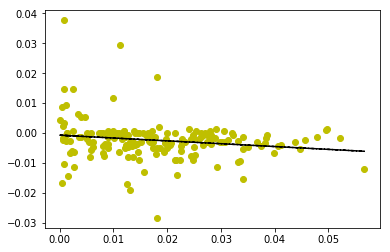

In [30]:
x = p21['diff'].values
y = p21['r'].values
m,b = np.polyfit(x, y, 1) 
plt.plot(x, y, 'yo', x, m*x+b, '--k') 
#x = sm.add_constant((x*100), prepend=True)
x=x*100
y=y*100
results = smf.OLS(y,x).fit()
display(results.summary())

距离正、斜率正：从相交点向上，线性回归显著，R2为70.4%

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     369.3
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           7.28e-43
Time:                        15:31:47   Log-Likelihood:                -104.02
No. Observations:                 156   AIC:                             210.0
Df Residuals:                     155   BIC:                             213.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2715      0.014     19.218      0.000       0.244       0.299
==============================================================================
Omnibus:                       18.545   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.541
Skew:                           0.807   Prob(JB):                     2.10e-05
Kurtosis:                       3.842   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

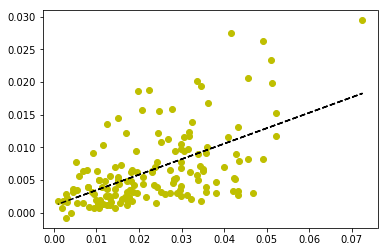

In [31]:
x = p22['diff'].values
y = p22['r'].values
m,b = np.polyfit(x, y, 1) 
plt.plot(x, y, 'yo', x, m*x+b, '--k') 
#x = sm.add_constant((x*100), prepend=True)
x=x*100
y=y*100
results = smf.OLS(y,x).fit()
display(results.summary())